In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_excel('British Airways Summer Schedule Dataset - Forage Data Science Task 1.xlsx')
df.head()

,FLIGHT_DATE,FLIGHT_TIME,TIME_OF_DAY,AIRLINE_CD,FLIGHT_NO,DEPARTURE_STATION_CD,ARRIVAL_STATION_CD,ARRIVAL_COUNTRY,ARRIVAL_REGION,HAUL,AIRCRAFT_TYPE,FIRST_CLASS_SEATS,BUSINESS_CLASS_SEATS,ECONOMY_SEATS,TIER1_ELIGIBLE_PAX,TIER2_ELIGIBLE_PAX,TIER3_ELIGIBLE_PAX
0,2025-09-02,14:19:00,Afternoon,BA,BA5211,LHR,LAX,USA,North America,LONG,B777,8,49,178,0,10,38
1,2025-06-10,06:42:00,Morning,BA,BA7282,LHR,LAX,USA,North America,LONG,B777,8,49,178,0,7,28
2,2025-10-27,15:33:00,Afternoon,BA,BA1896,LHR,FRA,Germany,Europe,SHORT,A320,0,17,163,0,11,40
3,2025-06-15,18:29:00,Evening,BA,BA5497,LHR,IST,Turkey,Europe,SHORT,A320,0,8,172,0,16,54
4,2025-08-25,20:35:00,Evening,BA,BA1493,LHR,FRA,Germany,Europe,SHORT,A320,0,13,167,0,6,27


In [3]:
df['DEPARTURE_STATION_CD'].nunique()

1

3


<Axes: >

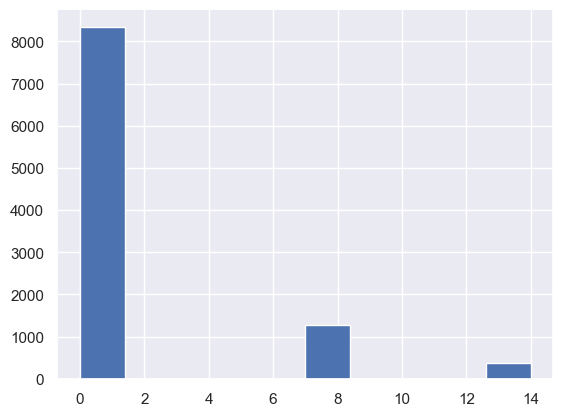

In [4]:
print(df['FIRST_CLASS_SEATS'].nunique())
df['FIRST_CLASS_SEATS'].hist()

Split data so we dont hard-code assumptions from this dataset since our model is meant to generalize to future BA schedules.

In [5]:
from sklearn.model_selection import train_test_split

# Random split (70% train, 30% test)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

print("Train size:", len(train_df))
print("Test size:", len(test_df))

Train size: 7000
Test size: 3000


 Checking the relationship between ARRIVAL_REGION, HAUL and AIRCRAFT_TYPE

In [6]:
# Check unique combinations of ARRIVAL_REGION, HAUL, and AIRCRAFT_TYPE
combo_counts = train_df.groupby(["ARRIVAL_REGION", "HAUL", "AIRCRAFT_TYPE"]).size().reset_index(name="count")

# Display the combinations sorted by frequency
print(combo_counts.sort_values("AIRCRAFT_TYPE", ascending=False))

# Check if each ARRIVAL_REGION maps to only one HAUL
region_haul = train_df.groupby("ARRIVAL_REGION")["HAUL"].nunique().reset_index(name="unique_haul_values")
print("\nUnique HAUL values per ARRIVAL_REGION:")
print(region_haul)

# Check if each HAUL maps to only one ARRIVAL_REGION
haul_region = train_df.groupby("HAUL")["ARRIVAL_REGION"].nunique().reset_index(name="unique_regions")
print("\nUnique ARRIVAL_REGION values per HAUL:")
print(haul_region)

# Check if AIRCRAFT_TYPE is only used in one HAUL category
aircraft_haul = train_df.groupby("AIRCRAFT_TYPE")["HAUL"].nunique().reset_index(name="unique_hauls")
print("\nUnique HAUL values per AIRCRAFT_TYPE:")
print(aircraft_haul)

   ARRIVAL_REGION   HAUL AIRCRAFT_TYPE  count
3            Asia   LONG          B787    146
8     Middle East   LONG          B787    138
12  North America   LONG          B787    570
2            Asia   LONG          B777    224
7     Middle East   LONG          B777    246
11  North America   LONG          B777    825
1            Asia   LONG          A380     47
6     Middle East   LONG          A380     36
10  North America   LONG          A380    190
0            Asia   LONG          A350     59
5     Middle East   LONG          A350     58
9   North America   LONG          A350    244
4          Europe  SHORT          A320   4217

Unique HAUL values per ARRIVAL_REGION:
  ARRIVAL_REGION  unique_haul_values
0           Asia                   1
1         Europe                   1
2    Middle East                   1
3  North America                   1

Unique ARRIVAL_REGION values per HAUL:
    HAUL  unique_regions
0   LONG               3
1  SHORT               1

Unique HAUL val

In [7]:
# Distinct FIRST_CLASS_SEATS by ARRIVAL_REGION
region_fc = train_df.groupby("ARRIVAL_REGION")["FIRST_CLASS_SEATS"].unique().reset_index()
print("Distinct FIRST_CLASS_SEATS by ARRIVAL_REGION:")
print(region_fc)

# Distinct FIRST_CLASS_SEATS by AIRCRAFT_TYPE
aircraft_fc = train_df.groupby("AIRCRAFT_TYPE")["FIRST_CLASS_SEATS"].unique().reset_index()
print("\nDistinct FIRST_CLASS_SEATS by AIRCRAFT_TYPE:")
print(aircraft_fc)

# Cross-check: ARRIVAL_REGION + AIRCRAFT_TYPE together
region_aircraft_fc = train_df.groupby(["ARRIVAL_REGION", "AIRCRAFT_TYPE"])["FIRST_CLASS_SEATS"].unique().reset_index()
print("\nDistinct FIRST_CLASS_SEATS by Region and Aircraft:")
print(region_aircraft_fc)

Distinct FIRST_CLASS_SEATS by ARRIVAL_REGION:
  ARRIVAL_REGION FIRST_CLASS_SEATS
0           Asia        [0, 8, 14]
1         Europe               [0]
2    Middle East        [8, 0, 14]
3  North America        [0, 8, 14]

Distinct FIRST_CLASS_SEATS by AIRCRAFT_TYPE:
  AIRCRAFT_TYPE FIRST_CLASS_SEATS
0          A320               [0]
1          A350               [0]
2          A380              [14]
3          B777            [8, 0]
4          B787            [0, 8]

Distinct FIRST_CLASS_SEATS by Region and Aircraft:
   ARRIVAL_REGION AIRCRAFT_TYPE FIRST_CLASS_SEATS
0            Asia          A350               [0]
1            Asia          A380              [14]
2            Asia          B777            [0, 8]
3            Asia          B787            [0, 8]
4          Europe          A320               [0]
5     Middle East          A350               [0]
6     Middle East          A380              [14]
7     Middle East          B777            [8, 0]
8     Middle East          

Since BA is planning far into the future, our model needs to be flexible and based on high-level groupings—not specific flight numbers or aircraft types. So we will group by: time of day, haul and arrival region.

In [8]:
grouped = train_df.groupby(['TIME_OF_DAY', 'HAUL', 'ARRIVAL_REGION'])

# Calculate average eligibility counts for each group
lookup_table = grouped[['TIER1_ELIGIBLE_PAX', 'TIER2_ELIGIBLE_PAX', 'TIER3_ELIGIBLE_PAX']].mean().round(2)
lookup_table

TIER1_ELIGIBLE_PAX  TIER2_ELIGIBLE_PAX  \
TIME_OF_DAY HAUL  ARRIVAL_REGION                                           
Afternoon   LONG  Asia                          0.50                8.80   
                  Middle East                   0.70                8.10   
                  North America                 0.61                8.20   
            SHORT Europe                        0.62                7.59   
Evening     LONG  Asia                          0.57                8.07   
                  Middle East                   0.62                7.96   
                  North America                 0.59                7.80   
            SHORT Europe                        0.61                8.05   
Lunchtime   LONG  Asia                          0.42                8.21   
                  Middle East                   0.50                6.60   
                  North America                 0.54                8.25   
            SHORT Europe                        0.67                8.27   
Morning     LONG  Asia                          0.51                7.76   
                  Middle East                   0.56                8.12   
                  North America                 0.59                8.31   
            SHORT Europe                        0.63                7.93   

                                  TIER3_ELIGIBLE_PAX  
TIME_OF_DAY HAUL  ARRIVAL_REGION                      
Afternoon   LONG  Asia                         32.88  
                  Middle East                  30.76  
                  North America                31.22  
            SHORT Europe                       29.32  
Evening     LONG  Asia                         30.83  
                  Middle East                  30.15  
                  North America                29.99  
            SHORT Europe                       30.73  
Lunchtime   LONG  Asia                         31.25  
                  Middle East                  26.25  
                  North America                31.36  
            SHORT Europe                       31.30  
Morning     LONG  Asia                         29.81  
                  Middle East                  30.89  
                  North America                31.55  
            SHORT Europe                       30.36

Look-up table where we include a hypothetical potential demand for Tier 1 (Concorde Room)

<Figure size 1200x600 with 0 Axes>

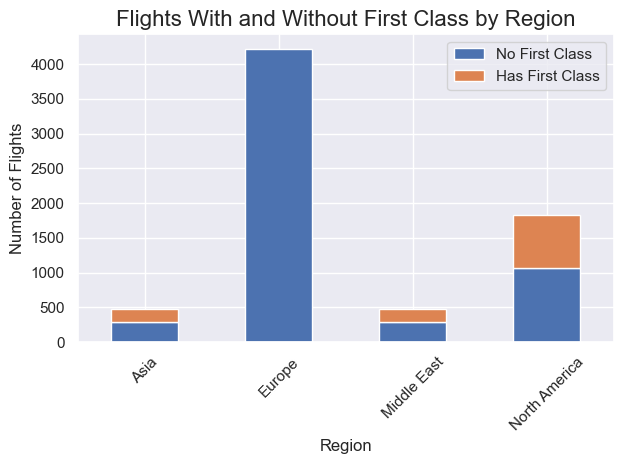

In [9]:
train_df['HAS_FIRST_CLASS'] = train_df['FIRST_CLASS_SEATS'] > 0

# Create the plot
plt.figure(figsize=(12, 6))
pd.crosstab(train_df['ARRIVAL_REGION'], train_df['HAS_FIRST_CLASS']).plot(kind='bar', stacked=True)
plt.title('Flights With and Without First Class by Region', fontsize=16)
plt.xlabel('Region')
plt.ylabel('Number of Flights')
plt.legend(['No First Class', 'Has First Class'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# Step 1: Create the Tier 1 estimate table (Region + Haul)
region_haul_config = train_df.groupby(['ARRIVAL_REGION', 'HAUL'])['FIRST_CLASS_SEATS'].mean().round(0).to_frame()
region_haul_config = region_haul_config.rename(columns={'FIRST_CLASS_SEATS': 'ESTIMATED_TIER1_PAX'})

# Step 2: Create the Tier 2 & 3 estimate table (Time + Region + Haul)
tier23_lookup = train_df.groupby(['TIME_OF_DAY', 'HAUL', 'ARRIVAL_REGION'])[['TIER2_ELIGIBLE_PAX', 'TIER3_ELIGIBLE_PAX']].mean().round(2)

# Step 3: Merge them together
# First, reset index of tier23_lookup to make the grouping columns regular columns
tier23_lookup_reset = tier23_lookup.reset_index()

# Then merge with region_haul_config on the common columns: ARRIVAL_REGION and HAUL
final_lookup_table = pd.merge(
    tier23_lookup_reset, 
    region_haul_config, 
    how='left', 
    on=['ARRIVAL_REGION', 'HAUL']
)

# Step 4: Set the index back if desired
final_lookup_table.set_index(['TIME_OF_DAY', 'HAUL', 'ARRIVAL_REGION'], inplace=True)
final_lookup_table

TIER2_ELIGIBLE_PAX  TIER3_ELIGIBLE_PAX  \
TIME_OF_DAY HAUL  ARRIVAL_REGION                                           
Afternoon   LONG  Asia                          8.80               32.88   
                  Middle East                   8.10               30.76   
                  North America                 8.20               31.22   
            SHORT Europe                        7.59               29.32   
Evening     LONG  Asia                          8.07               30.83   
                  Middle East                   7.96               30.15   
                  North America                 7.80               29.99   
            SHORT Europe                        8.05               30.73   
Lunchtime   LONG  Asia                          8.21               31.25   
                  Middle East                   6.60               26.25   
                  North America                 8.25               31.36   
            SHORT Europe                        8.27               31.30   
Morning     LONG  Asia                          7.76               29.81   
                  Middle East                   8.12               30.89   
                  North America                 8.31               31.55   
            SHORT Europe                        7.93               30.36   

                                  ESTIMATED_TIER1_PAX  
TIME_OF_DAY HAUL  ARRIVAL_REGION                       
Afternoon   LONG  Asia                            4.0  
                  Middle East                     4.0  
                  North America                   4.0  
            SHORT Europe                          0.0  
Evening     LONG  Asia                            4.0  
                  Middle East                     4.0  
                  North America                   4.0  
            SHORT Europe                          0.0  
Lunchtime   LONG  Asia                            4.0  
                  Middle East                     4.0  
                  North America                   4.0  
            SHORT Europe                          0.0  
Morning     LONG  Asia                            4.0  
                  Middle East                     4.0  
                  North America                   4.0  
            SHORT Europe                          0.0

In [12]:
# Calculate total passengers for each flight
train_df['TOTAL_PAX'] = train_df['FIRST_CLASS_SEATS'] + train_df['BUSINESS_CLASS_SEATS'] + train_df['ECONOMY_SEATS']

# Group by the required categories
grouped = train_df.groupby(['TIME_OF_DAY', 'HAUL', 'ARRIVAL_REGION'])

# Create the lookup table with percentages
lookup_table = grouped.agg({
    'TIER1_ELIGIBLE_PAX': 'mean',  # These will be converted to %
    'TIER2_ELIGIBLE_PAX': 'mean',
    'TIER3_ELIGIBLE_PAX': 'mean',
    'TOTAL_PAX': 'mean'
}).round(2)

# Calculate percentages
lookup_table['TIER1_PCT'] = (lookup_table['TIER1_ELIGIBLE_PAX'] / lookup_table['TOTAL_PAX'] * 100).round(2)
lookup_table['TIER2_PCT'] = (lookup_table['TIER2_ELIGIBLE_PAX'] / lookup_table['TOTAL_PAX'] * 100).round(2)
lookup_table['TIER3_PCT'] = (lookup_table['TIER3_ELIGIBLE_PAX'] / lookup_table['TOTAL_PAX'] * 100).round(2)

# Select only the percentage columns for your submission
submission_table = lookup_table[['TIER1_PCT', 'TIER2_PCT', 'TIER3_PCT']].reset_index()

submission_table

,TIME_OF_DAY,HAUL,ARRIVAL_REGION,TIER1_PCT,TIER2_PCT,TIER3_PCT
0,Afternoon,LONG,Asia,0.17,2.99,11.17
1,Afternoon,LONG,Middle East,0.24,2.76,10.50
2,Afternoon,LONG,North America,0.21,2.83,10.79
3,Afternoon,SHORT,Europe,0.34,4.22,16.29
4,Evening,LONG,Asia,0.20,2.83,10.80
5,Evening,LONG,Middle East,0.21,2.73,10.33
6,Evening,LONG,North America,0.20,2.65,10.21
7,Evening,SHORT,Europe,0.34,4.47,17.07
8,Lunchtime,LONG,Asia,0.14,2.76,10.49
9,Lunchtime,LONG,Middle East,0.18,2.44,9.70
